In [0]:
import pandas as pd
import numpy as np
import torch

from tqdm import tqdm_notebook
from random import randint
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F

from torch import nn, optim, tensor

from IPython.display import clear_output
from matplotlib import pylab as plt

https://www.ijcai.org/proceedings/2017/0446.pdf

https://grouplens.org/datasets/hetrec-2011/

### Load datasets

Выкачиваем выборку

In [0]:
del_df = pd.read_csv(
    'https://raw.githubusercontent.com/bobrovskayaa/learning-deep-learning/journal-club/homeworks/journal-club/delicious/user_taggedbookmarks.dat',
    sep='\t',
    nrows=200000
)

In [0]:
del_df.head()

,userID,bookmarkID,tagID,day,month,year,hour,minute,second
0,8,1,1,8,11,2010,23,29,22
1,8,2,1,8,11,2010,23,25,59
2,8,7,1,8,11,2010,18,55,1
3,8,7,6,8,11,2010,18,55,1
4,8,7,7,8,11,2010,18,55,1


In [0]:
# del_tags = pd.read_fwf(
#     'https://raw.githubusercontent.com/bobrovskayaa/learning-deep-learning/journal-club/homeworks/journal-club/delicious/tags.dat',
#     sep='\t'
# )["id\tvalue"].str.split("\t", n = 1, expand = True)

In [0]:
# lf_df = pd.read_csv(
#     'https://raw.githubusercontent.com/bobrovskayaa/learning-deep-learning/journal-club/homeworks/journal-club/lastfm/user_taggedartists.dat',
#     sep='\t'
# )

In [0]:
# lf_tags = pd.read_fwf('./lastfm/tags.dat', sep='\t')["tagID\ttagValue"].str.split("\t", n = 1, expand = True)

__________________

### Choose dataset

In [0]:
user_column = 'userID'
item_column = 'bookmarkID'
tag_column = 'tagID'

In [0]:
df = del_df[[user_column, item_column, tag_column]].copy()

We randomly select 80% of the assignment data as training set, 5% as validation set, and 15% as test set.

In [0]:
train, test = train_test_split(df, test_size=0.2, random_state=1)
test, val = train_test_split(test, test_size=0.25, random_state=1)

Для пользователя и для тэгов

<img src="https://raw.githubusercontent.com/bobrovskayaa/learning-deep-learning/journal-club/homeworks/journal-club/images/profiles.png" width="400">

Для каждого пользователя и объекта получим его представление через тэги

In [0]:
def get_dict(df, key_col, item_col):
    n = len(df[item_col].unique())
    item2id = dict(zip(df[item_col].unique(), range(n)))
    dict_u_keys = {}

    for i, row in tqdm_notebook(df.iterrows()):
        ans = dict_u_keys.get(row[key_col], np.zeros(n, dtype=np.float64))
        idx = item2id.get(row[item_col])
        ans[idx] += 1
        dict_u_keys[row[key_col]] = ans
    return dict_u_keys

In [0]:
dict_users = get_dict(train, user_column, tag_column)

In [0]:
list(dict_users.items())[0]

(5024, array([ 7., 25.,  0., ...,  0.,  0.,  0.]))

In [0]:
dict_items = get_dict(train, item_column, tag_column)

_______________
### Generate model input

In [0]:
n_users = len(list(dict_users.items())[0][1])
n_items = len(list(dict_items.items())[0][1])
print(n_users, n_items)

22009 22009


In [0]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [0]:
BATCH_SIZE = 128
def generate_model_input(df, user_column, item_column,
                         batch_size=BATCH_SIZE):
    n = df.shape[0]
    batch = []
    
    for i in range(BATCH_SIZE):
        row_id = randint(0, n-1)
        row = df.iloc[row_id]
        
        anchor = row[user_column]
        item_pos = row[item_column]
        
        neg_row_id = randint(0, n-1)
        neg_row = df.iloc[row_id]
        
        item_neg = neg_row[item_column]
        
        batch.append([
            dict_users.get(anchor, np.zeros(n_users)),
            dict_items.get(item_pos, np.zeros(n_items)),
            dict_items.get(item_neg, np.zeros(n_items))
        ])
        
    anchors = tensor(np.array([x[0] for x in batch]), dtype=torch.float, device=device)
    pos_items = tensor(np.array([x[1] for x in batch]), dtype=torch.float, device=device)
    neg_items = tensor(np.array([x[2] for x in batch]), dtype=torch.float, device=device)
    return anchors, pos_items, neg_items

In [0]:
anchors, pos_items, neg_items = generate_model_input(
    train, user_column, item_column
)
print(anchors.shape, pos_items.shape, neg_items.shape)

torch.Size([128, 22009]) torch.Size([128, 22009]) torch.Size([128, 22009])


In [0]:
print(anchors[0][0:100])

tensor([0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


_____
### DSPR

<img src="https://raw.githubusercontent.com/bobrovskayaa/learning-deep-learning/journal-club/homeworks/journal-club/images/dspr.png" width="400">

The parameters of DSPR set as follows:
* num of hidden layers (i.e., K) is 3;
* num of neurons in the 1st, 2nd, and 3rd hidden layers are 2 000, 300, and 128, respectively;
* training batch size is 128;
* learning rate for model training is 0.005

In [0]:
class DSPR(nn.Module):
    def __init__(self, n_in):
        super(DSPR, self).__init__()
        self.dspr = nn.Sequential(
            nn.Linear(n_in, 2000),
            nn.Tanh(),
            nn.Linear(2000, 300),
            nn.Tanh(),
            nn.Linear(300, 128),
            nn.Tanh()
        )

    def forward(self, input_init):
        return self.dspr(input_init)

<img src="https://raw.githubusercontent.com/bobrovskayaa/learning-deep-learning/journal-club/homeworks/journal-club/images/rlv.png" width="400">

<img src="https://raw.githubusercontent.com/bobrovskayaa/learning-deep-learning/journal-club/homeworks/journal-club/images/dspr_loss.png" width="400">

In [0]:
def softmax(x):
    return x.exp() / (x.exp().sum(-1)).unsqueeze(-1)

def nl(x):
    return - x.log().sum()

In [0]:
class DSPRLoss(nn.Module):
    def __init__(self):
        super(DSPRLoss, self).__init__()

    def forward(self, input1, input2):
        cos_sim = F.cosine_similarity(input1, input2)
        loss = nl(softmax(cos_sim))
        return loss

_____
DSPR

In [0]:
# from tensorboardX import SummaryWriter
# from datetime import datetime
# import os

# experiment_title = 'delicious-DSPR'
# experiment_name = "{}_{}".format(experiment_title, datetime.now().strftime("%d.%m.%Y-%H.%M.%S"))
# writer = SummaryWriter(log_dir=os.path.join("./logs", experiment_name))

model_dspr = DSPR(n_items)
model_dspr = model_dspr.to(device)

criterion_dspr = DSPRLoss()
opt_dspr = optim.SGD(model_dspr.parameters(), lr = 0.005) #optim.Adam(model_dspr.parameters(), lr=0.0002)

In [0]:
print(train.shape[0] // BATCH_SIZE, val.shape[0] // BATCH_SIZE)

1250 78


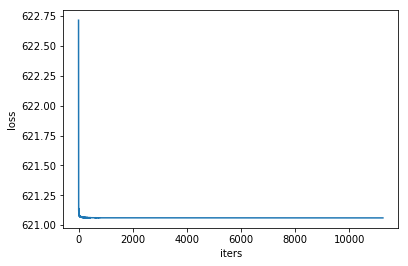

[epoch 8] loss: 621.0599865722656 val loss: 621.0599639110076


KeyboardInterrupt: ignored

In [0]:
n_epochs = 20
n_batches = train.shape[0] // BATCH_SIZE
n_batches_val = val.shape[0] // BATCH_SIZE
n_iters_total = 0
n_iters_total_val = 0

losses = []
losses_val = []

for epoch in range(n_epochs):
    running_loss = 0.
    running_val_loss = 0.
    
    for i in tqdm_notebook(range(n_batches)):
        # unpack batch
        anchors_init, pos_items_init, _ = generate_model_input(
            train, user_column, item_column
        )
        
        # forward
        user = model_dspr(anchors_init)
        pos_items = model_dspr(pos_items_init)
        loss = criterion_dspr(user, pos_items)
        
        # optimize
        opt_dspr.zero_grad()
        loss.backward()
        opt_dspr.step()
        
        running_loss += loss.item()
        
        # dump statistics
        # writer.add_scalar("train/loss", loss.item(), global_step=n_iters_total)
        losses.append(loss.item())
        n_iters_total += 1
        
    model_dspr.eval()
    with torch.no_grad():
        for i in tqdm_notebook(range(n_batches_val)):
            # unpack batch
            anchors_init, pos_items_init, _ = generate_model_input(
                val, user_column, item_column
            )
            
            # forward
            user = model_dspr(anchors_init)
            pos_items = model_dspr(pos_items_init)
            loss = criterion_dspr(user, pos_items)

            running_val_loss += loss.item()

            # dump statistics
            # writer.add_scalar("val/loss", loss.item(), global_step=n_iters_total_val)
            losses_val.append(loss.item())
            n_iters_total_val += 1
            
    clear_output(True)
    plt.plot(losses)
    plt.xlabel("iters")
    plt.ylabel("loss");
    plt.show()
    
    print("[epoch {}] loss: {} val loss: {}".format(epoch, running_loss / n_batches, running_val_loss / n_batches_val))

In [0]:
# n_epochs = 20

# for epoch in range(n_epochs, n_epochs*2):
#     running_loss = 0.
#     running_val_loss = 0.
    
#     for i in tqdm_notebook(range(n_batches)):
#         # unpack batch
#         anchors_init, pos_items_init, _ = generate_model_input(
#             train, user_column, item_column
#         )
        
#         # forward
#         user = model_dspr(anchors_init)
#         pos_items = model_dspr(pos_items_init)
#         loss = criterion_dspr(user, pos_items)
        
#         # optimize
#         opt_dspr.zero_grad()
#         loss.backward()
#         opt_dspr.step()
        
#         running_loss += loss.item()
        
#         # dump statistics
#         # writer.add_scalar("train/loss", loss.item(), global_step=n_iters_total)
#         losses.append(loss.item())
#         n_iters_total += 1
        
#     model_dspr.eval()
#     with torch.no_grad():
#         for i in tqdm_notebook(range(n_batches_val)):
#             # unpack batch
#             anchors_init, pos_items_init, _ = generate_model_input(
#                 val, user_column, item_column
#             )
            
#             # forward
#             user = model_dspr(anchors_init)
#             pos_items = model_dspr(pos_items_init)
#             loss = criterion_dspr(user, pos_items)

#             running_val_loss += loss.item()

#             # dump statistics
#             # writer.add_scalar("val/loss", loss.item(), global_step=n_iters_total_val)
#             losses_val.append(loss.item())
#             n_iters_total_val += 1
            
#     clear_output(True)
#     plt.plot(losses)
#     plt.xlabel("iters")
#     plt.ylabel("loss");
#     plt.show()
    
#     print("[epoch {}] loss: {} val loss: {}".format(epoch, running_loss / n_batches, running_val_loss / n_batches_val))

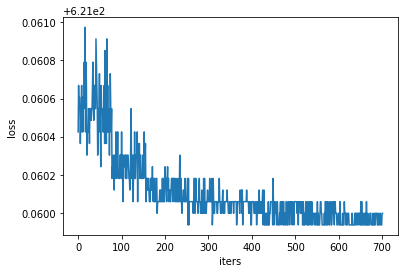

In [0]:
plt.plot(losses_val)
plt.xlabel("iters")
plt.ylabel("loss");
plt.show()

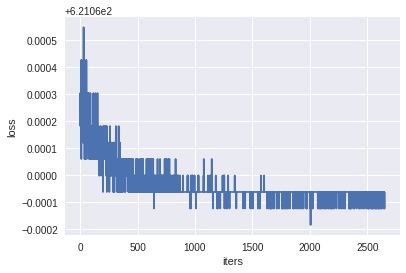

In [0]:
plt.plot(losses_val)
plt.xlabel("iters")
plt.ylabel("loss");
plt.show()

____

### HDLPR

<img src="https://raw.githubusercontent.com/bobrovskayaa/learning-deep-learning/journal-club/homeworks/journal-club/images/hdlpr.png" width="400">

In [0]:
class HDLPR(nn.Module):
    def __init__(self, n_in):
        super(HDLPR, self).__init__()
        self.dspr = nn.Sequential(
            nn.Linear(n_in, 2000),
            nn.Tanh(),
            nn.Linear(2000, 300),
            nn.Tanh(),
            nn.Linear(300, 128),
            nn.Tanh()
        )
        self.up = nn.Sequential(
            nn.Linear(128, 300),
            nn.Tanh(),
            nn.Linear(300, 2000),
            nn.Tanh(),
            nn.Linear(2000, n_in),
            nn.Tanh()
        )

    def forward(self, input_init):
        input_latent = self.dspr(input_init)
        input_final = self.up(input_latent)
        return input_latent, input_final

<img src="https://raw.githubusercontent.com/bobrovskayaa/learning-deep-learning/journal-club/homeworks/journal-club/images/hdlpr_loss.png" width="400">

In [0]:
class HDLPR_Loss(nn.Module):
    def __init__(self):
        super(HDLPR_Loss, self).__init__()
        self.lambda0 = 0.01
        self.lambda1 = 0.2
        
    def l2_regularizer(self, parameters):
        l2_reg = None
        for W in parameters:
            if l2_reg is None:
                l2_reg = W.norm(2)
            else:
                l2_reg = l2_reg + W.norm(2)
        return l2_reg

    def forward(self, input1_init, input2_init, input1_latent, input2_latent, input1, input2, parameters):
        reconstruction_error = (
            torch.norm(input1 - input1_init, 2, dim = 1) + torch.norm(input2 - input2_init, 2, dim = 1)).sum()

        cos_sim_loss = nl(softmax(F.cosine_similarity(input1_latent, input2_latent)))
        loss = self.lambda1 * reconstruction_error + (1 - self.lambda0 - self.lambda1) * cos_sim_loss + self.lambda0 * self.l2_regularizer(parameters)
        return loss

In [0]:
# class TripletLoss(nn.Module):
#     '''
#     Compute normal triplet loss or soft margin triplet loss given triplets
#     '''
#     def __init__(self, margin = None):
#         super(TripletLoss, self).__init__()
#         self.margin = margin
#         if self.margin is None:  # use soft-margin
#             self.triplet_loss = nn.SoftMarginLoss()
#         else:
#             self.triplet_loss = nn.TripletMarginLoss(margin = margin, p = 2)

#     def forward(self, anchor, pos, neg):
#         # triplet loss
#         if self.margin is None:
#             num_samples = anchor.shape[0]
#             y = torch.ones((num_samples, 1)).view(-1)
#             if anchor.is_cuda: y = y.cuda()
#             ap_dist = torch.norm(anchor - pos, 2, dim = 1).view(-1)
#             an_dist = torch.norm(anchor - neg, 2, dim = 1).view(-1)
#             triplet_loss = self.triplet_loss(an_dist - ap_dist, y)
#         else:
#             triplet_loss = self.triplet_loss(anchor, pos, neg)
            
#         loss = triplet_loss

#         return loss

In [0]:
# experiment_title = 'delicious-HDLPR'
# experiment_name = "{}_{}".format(experiment_title, datetime.now().strftime("%d.%m.%Y-%H.%M.%S"))
# writer = SummaryWriter(log_dir=os.path.join("./logs", experiment_name))

model_hdpr = HDLPR(n_items)
model_hdpr = model_hdpr.to(device)

criterion_hdpr = HDLPR_Loss()
opt_hdpr = optim.SGD(model_hdpr.parameters(), lr = 0.005) #optim.Adam(model_hdpr.parameters(), lr=0.0002)

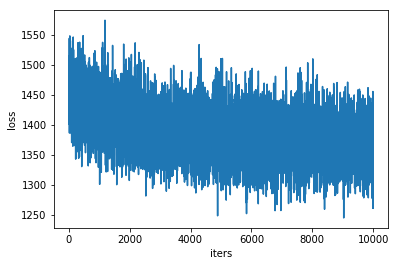

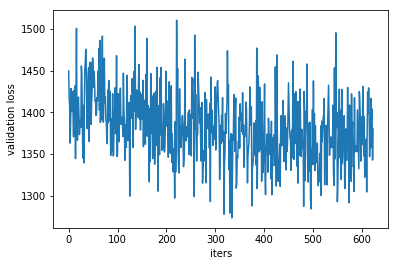

[epoch 7] loss: 1370.255712109375 val loss: 1372.295178535657


KeyboardInterrupt: ignored

In [0]:
n_epochs = 20
n_batches = train.shape[0] // BATCH_SIZE
n_batches_val = val.shape[0] // BATCH_SIZE
n_iters_total_2 = 0
n_iters_total_val_2 = 0

losses_2 = []
losses_val_2 = []

for epoch in range(n_epochs):
    running_loss = 0.
    running_val_loss = 0.
    
    for i in tqdm_notebook(range(n_batches)):
        # unpack batch
        anchors_init, pos_items_init, _ = generate_model_input(
            train, user_column, item_column
        )
        
        # forward
        user_latent, user_final = model_hdpr(anchors_init)
        pos_items_latent, pos_items_final = model_hdpr(pos_items_init)
        loss = criterion_hdpr(
            anchors_init, pos_items_init,
            user_latent, pos_items_latent,
            user_final, pos_items_final,
            model_hdpr.parameters()
        ) 

        # optimize
        opt_hdpr.zero_grad()
        loss.backward()
        opt_hdpr.step()
        
        running_loss += loss.item()
        
        # dump statistics
        # writer.add_scalar("train/loss", loss.item(), global_step=n_iters_total)
        losses_2.append(loss.item())
        n_iters_total_2 += 1
        
    model_hdpr.eval()
    with torch.no_grad():
        for i in tqdm_notebook(range(n_batches_val)):
            # unpack batch
            anchors_init, pos_items_init, _ = generate_model_input(
                val, user_column, item_column
            )
            
            # forward
            user_latent, user_final = model_hdpr(anchors_init)
            pos_items_latent, pos_items_final = model_hdpr(pos_items_init)
            loss = criterion_hdpr(
                anchors_init, pos_items_init,
                user_latent, pos_items_latent,
                user_final, pos_items_final,
                model_hdpr.parameters()
            )

            running_val_loss += loss.item()

            # dump statistics
            # writer.add_scalar("val/loss", loss.item(), global_step=n_iters_total_val)
            losses_val_2.append(loss.item())
            n_iters_total_val_2 += 1
            
    clear_output(True)
    plt.plot(losses_2)
    plt.xlabel("iters")
    plt.ylabel("loss");
    plt.show()
    
    plt.plot(losses_val_2)
    plt.xlabel("iters")
    plt.ylabel("validation loss");
    plt.show()
    
    print("[epoch {}] loss: {} val loss: {}".format(epoch, running_loss / n_batches, running_val_loss / n_batches_val))

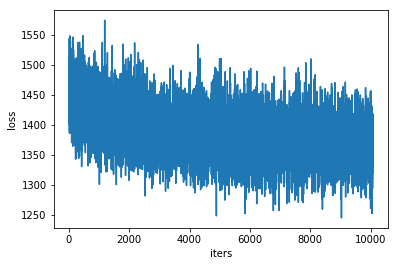

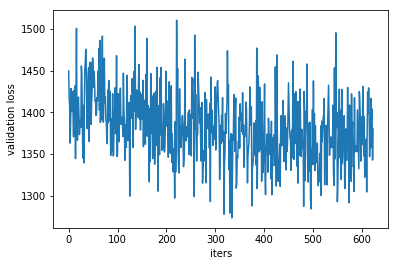

In [0]:
plt.plot(losses_2)
plt.xlabel("iters")
plt.ylabel("loss");
plt.show()

plt.plot(losses_val_2)
plt.xlabel("iters")
plt.ylabel("validation loss");
plt.show()

______________
### HDLPR_NS

In [0]:
class HDLPR_NS_Loss(nn.Module):
    def __init__(self):
        super(HDLPR_NS_Loss, self).__init__()
        self.lambda0 = 0.01
        self.lambda1 = 0.2
                
    def l2_regularizer(self, parameters):
        l2_reg = None
        for W in parameters:
            if l2_reg is None:
                l2_reg = W.norm(2)
            else:
                l2_reg = l2_reg + W.norm(2)
        return l2_reg

    def forward(self,
                input1_init, input2_init,
                input1_latent, input2_latent, input3_latent,
                input1, input2,
                parameters):

        reconstruction_error = (
            torch.norm(input1 - input1_init, 2, dim = 1) + torch.norm(input2 - input2_init, 2, dim = 1)).sum()

        cos_sim_pos = F.cosine_similarity(input1_latent, input2_latent)
        cos_sim_neg = F.cosine_similarity(input1_latent, input3_latent)
        cos_sim_loss = nl(softmax(cos_sim_pos - cos_sim_neg))
        return self.lambda1 * reconstruction_error + (1 - self.lambda0 - self.lambda1) * cos_sim_loss + self.lambda0 * self.l2_regularizer(parameters)

In [0]:
# experiment_title = 'delicious-HDLPR_NS'
# experiment_name = "{}_{}".format(experiment_title, datetime.now().strftime("%d.%m.%Y-%H.%M.%S"))
# writer = SummaryWriter(log_dir=os.path.join("./logs", experiment_name))

model_hdpr_ns = HDLPR(n_items)
model_hdpr_ns = model_hdpr_ns.to(device)

criterion_hdpr_ns = HDLPR_NS_Loss()
opt_hdpr_ns = optim.SGD(model_hdpr_ns.parameters(), lr = 0.005) #optim.Adam(model_hdpr_ns.parameters(), lr=0.0002)

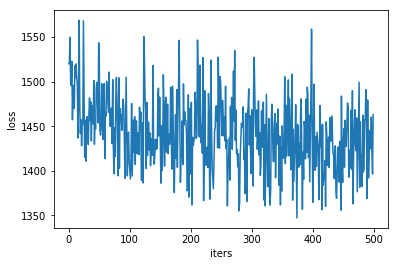

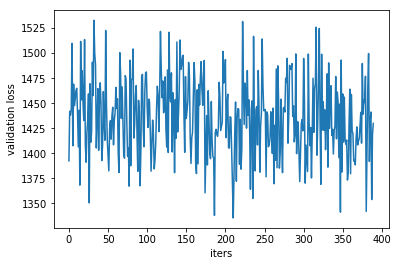

[epoch 4] loss: 1425.1603308105468 val loss: 1430.9725153996394


In [0]:
n_epochs = 5
n_batches = 100 # train.shape[0] // BATCH_SIZE
n_batches_val = val.shape[0] // BATCH_SIZE
n_iters_total_ns = 0
n_iters_total_val_ns = 0

losses_ns = []
losses_val_ns = []

for epoch in range(n_epochs):
    running_loss = 0.
    running_val_loss = 0.
    
    for i in tqdm_notebook(range(n_batches)):
        # unpack batch
        anchors_init, pos_items_init, neg_items_init = generate_model_input(
            train, user_column, item_column
        )
        
        # forward
        anchors_latent, anchors_final = model_hdpr_ns(anchors_init)
        pos_items_latent, pos_items_final = model_hdpr_ns(pos_items_init)
        neg_items_latent, neg_items_final = model_hdpr_ns(neg_items_init)
        
        loss = criterion_hdpr_ns(
            anchors_init, pos_items_init,
            anchors_latent, pos_items_latent, neg_items_latent,
            anchors_final, pos_items_final,
            model_hdpr_ns.parameters()
        )
        
        # optimize
        opt_hdpr_ns.zero_grad()
        loss.backward()
        opt_hdpr_ns.step()
        
        running_loss += loss.item()
        
        # dump statistics
#         writer.add_scalar("train/loss", loss.item(), global_step=n_iters_total)
        losses_ns.append(loss.item())
        n_iters_total_ns += 1
        
    model_hdpr_ns.eval()
    with torch.no_grad():
        for i in tqdm_notebook(range(n_batches_val)):
        # unpack batch
            anchors_init, pos_items_init, neg_items_init = generate_model_input(
                val, user_column, item_column
            )

            # forward
            anchors_latent, anchors_final = model_hdpr_ns(anchors_init)
            pos_items_latent, pos_items_final = model_hdpr_ns(pos_items_init)
            neg_items_latent, neg_items_final = model_hdpr_ns(neg_items_init)

            loss = criterion_hdpr_ns(
                anchors_init, pos_items_init,
                anchors_latent, pos_items_latent, neg_items_latent,
                anchors_final, pos_items_final,
                model_hdpr_ns.parameters()
            )

            running_val_loss += loss.item()

            # dump statistics
#             writer.add_scalar("val/loss", loss.item(), global_step=n_iters_total_val)
            losses_val_ns.append(loss.item())
            n_iters_total_val_ns += 1

    print("[epoch {}] loss: {:.3} val loss: {:.3}".format(epoch, running_loss / train.shape[0], running_val_loss / val.shape[0]))
    
    clear_output(True)
    plt.plot(losses_ns)
    plt.xlabel("iters")
    plt.ylabel("loss");
    plt.show()
    
    plt.plot(losses_val_ns)
    plt.xlabel("iters")
    plt.ylabel("validation loss");
    plt.show()
    
    print("[epoch {}] loss: {} val loss: {}".format(epoch, running_loss / n_batches, running_val_loss / n_batches_val))

## Testing

In [0]:
def get_prediction(user_id, item_id):
    user_vector = dict_users.get(user_id, np.zeros(n_users))
    item_vector = dict_items.get(item_id, np.zeros(n_items))
    
    user_vector = tensor([user_vector], dtype=torch.float, device=device)
    item_vector = tensor([item_vector], dtype=torch.float, device=device)

    model.eval()
    with torch.no_grad():
#         user = model(user_vector)
#         item = model(item_vector)

        user, _ = model(user_vector)
        item, _ = model(item_vector)

#         print('user', user)
#         print('item', item)
        return F.cosine_similarity(user, item).item()

In [0]:
def RR(predicted_item_list, real_items, k):
    rr = 0
    for idx, item in enumerate(predicted_item_list[:k]):
        if item[1] in real_items:
            rr = 1/(idx+1)
            break
    return np.mean(rr)
  
def AP(predicted_item_list, real_items, k):
    prec = 0
    for item in predicted_item_list[:k]:
        if item[1] in real_items:
            prec += 1
    return np.mean(prec)
  
def AR(predicted_item_list, real_items, k):
    n = len(real_items)
    recall = 0
    for item in predicted_item_list[:k]:
        if item[1] in real_items:
            recall += 1
    return recall / n if n > 0 else 0
  
def get_mean_metric(predictions_dict, metric, k):
    metric_array = []
    for user_id, sorted_item_list in predictions_dict.items():
        metric_array.append(metric(sorted_item_list, user_by_bookmarks_test[user_id], k))
    return np.mean(metric_array)

Так, 𝑃@𝑘 — доля релевантных
документов (тех, которые оказались интересны пользователю, рекомендации,
которые он просмотрел) среди первых 𝑘 документов из отранжированного списка
рекомендаций. 𝑅@𝑘 — доля релевантных документов из топ-𝑘 списка рекомендаций
среди всех релевантных документов по данному запросу.

In [0]:
def AF(prec, recall):
    return (2 * prec * recall) / (prec + recall)

In [0]:
k_array = list(range(5, 51, 5))

def get_metrics(predictions_dict):
    arr_mrr = []
    arr_precision = []
    arr_recall = []
    arr_f = []

    for k in k_array:
        print('k =', k)

        metric_mrr = get_mean_metric(predictions_dict, RR, k)
        arr_mrr.append(metric_mrr)
        print('mrr:', metric_mrr)

        metric_precision = get_mean_metric(predictions_dict, AR, k)
        arr_precision.append(metric_precision)
        print('precision:', metric_precision)

        metric_recall = get_mean_metric(predictions_dict, AR, k)
        arr_recall.append(metric_recall)
        print('recall:', metric_recall)

        metric_f = AF(metric_precision, metric_recall)
        arr_f.append(metric_f)
        print('f-score:', metric_f)

    return {'mrr': arr_mrr, 'precision': arr_precision, 'recall': arr_recall, 'f-score':arr_f}

In [0]:
test_items = list(test[item_column].unique())
test_users = list(test[user_column].unique())[:50]
user_by_bookmarks_all = dict(df.groupby([user_column])[item_column].apply(list))
user_by_bookmarks_test = dict(test.groupby([user_column])[item_column].apply(list))

In [0]:
list(user_by_bookmarks_all.keys())[:10], list(user_by_bookmarks_test.keys())[:10]

([8, 32, 57, 147, 233, 242, 259, 302, 319, 336],
 [8, 32, 57, 147, 233, 242, 259, 302, 319, 336])

In [0]:
print(user_by_bookmarks_all[8])
print(user_by_bookmarks_test[8])

[1, 2, 7, 7, 7, 8, 8, 8, 9, 9, 10, 10, 11, 11, 11, 14, 14, 14, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 22, 22, 22, 24, 24, 25, 25, 26, 26, 27, 27, 30, 30, 32, 32, 33, 33, 34, 34, 35, 35, 36, 36, 37, 37, 38, 38, 41, 42, 43, 44, 45, 46, 48, 48, 48, 48, 52, 53, 53, 53, 53, 53, 58, 58, 59, 60, 60, 61, 61, 62, 63, 64, 65, 68, 68, 68, 71, 72, 72, 73, 73, 73, 74, 74, 74, 74, 75, 75, 75, 76, 76, 78, 78, 78, 78, 79, 79, 79, 79, 79, 79, 79, 80, 80, 80, 80, 81, 81, 82, 82, 82, 82, 83, 83, 83, 84, 84, 85, 85, 87, 87, 87, 87, 88, 88, 88, 88, 88, 89, 89, 90, 91, 92, 93, 93, 93, 94, 96, 98, 99]
[2, 88, 73, 19, 41, 11, 90, 68, 17, 63, 72, 48, 53, 36, 88, 60, 11, 59, 44, 48, 15, 85, 73, 7, 37, 75, 74, 79, 80, 89, 94]


In [0]:
user_id = 8
item_list = []
for item_id in test_items:
    item_list.append((get_prediction(user_id, item_id), item_id))
item_list.sort(reverse=True)
print(item_list[:100])

[(0.6956499218940735, 6130), (0.6951133608818054, 99), (0.6647517085075378, 5825), (0.6424378752708435, 28550), (0.6376649141311646, 27787), (0.6320866942405701, 11474), (0.6279029250144958, 28812), (0.6201627850532532, 11661), (0.6193066835403442, 35539), (0.6101894974708557, 29118), (0.6023967266082764, 1831), (0.6017177104949951, 57959), (0.5987955331802368, 57966), (0.5983433127403259, 57962), (0.5965853929519653, 27964), (0.5938818454742432, 31770), (0.5916613340377808, 27790), (0.587522029876709, 17111), (0.5850503444671631, 17356), (0.5838128328323364, 11371), (0.5815487504005432, 5892), (0.5791038274765015, 57708), (0.5778571963310242, 25247), (0.5760976672172546, 38700), (0.5746745467185974, 36865), (0.5726427435874939, 21749), (0.572522759437561, 2797), (0.5703844428062439, 36898), (0.570207953453064, 5902), (0.5695244669914246, 9621), (0.567832887172699, 28553), (0.5670778155326843, 27815), (0.566370964050293, 19), (0.5663427114486694, 25252), (0.5662646889686584, 55508), (0

In [0]:
model = model_hdpr

In [0]:
for i in range(10):
  print('cos_sim', get_prediction(test_users[i], test_items[i]))

cos_sim 0.17092953622341156
cos_sim 0.49547919631004333
cos_sim 0.40940067172050476
cos_sim 0.30242815613746643
cos_sim 0.24970832467079163
cos_sim 0.18024376034736633
cos_sim 0.3386620879173279
cos_sim 0.15356183052062988
cos_sim 0.30381760001182556
cos_sim 0.4030954837799072


In [0]:
predictions_dict_hdpr = {}

for user_id in tqdm_notebook(test_users):
    item_list = []
    for item_id in test_items:
        item_list.append((get_prediction(user_id, item_id), item_id))
    item_list.sort(reverse=True)
    predictions_dict_hdpr[user_id] = item_list

In [0]:
metrics_hdpr = get_metrics(predictions_dict_hdpr)

In [0]:
def plot_metric(metric_name):
    plt.plot(k_array, metrics_hdpr[metric_name], label='hdpr')
    plt.title(metric_name+"@k")
    plt.xlabel("k")
    plt.ylabel(metric_name+"@k")
    plt.legend()
    plt.show()

In [0]:
plot_metric('mrr')
plot_metric('precision')
plot_metric('recall')
plot_metric('f-score')

In [0]:
model = model_hdpr_ns


predictions_dict_hdpr_ns = {}

for user_id in tqdm_notebook(test_users):
    item_list = []
    for item_id in test_items:
        item_list.append((get_prediction(user_id, item_id), item_id))
    item_list.sort(reverse=True)
    predictions_dict_hdpr_ns[user_id] = item_list

In [0]:
metrics_hdpr_ns = get_metrics(predictions_dict_hdpr_ns)

In [0]:
def get_prediction(user_id, item_id):
    user_vector = dict_users.get(user_id, np.zeros(n_users))
    item_vector = dict_items.get(item_id, np.zeros(n_items))
    
    user_vector = tensor([user_vector], dtype=torch.float, device=device)
    item_vector = tensor([item_vector], dtype=torch.float, device=device)

    model.eval()
    with torch.no_grad():
        user = model(user_vector)
        item = model(item_vector)

#         user, _ = model(user_vector)
#         item, _ = model(item_vector)

#         print('user', user)
#         print('item', item)
        return F.cosine_similarity(user, item).item()

In [0]:
model = model_dspr


predictions_dict_dspr = {}

for user_id in tqdm_notebook(test_users):
    item_list = []
    for item_id in test_items:
        item_list.append((get_prediction(user_id, item_id), item_id))
    item_list.sort(reverse=True)
    predictions_dict_dspr[user_id] = item_list

In [0]:
metrics_dspr = get_metrics(predictions_dict_dspr)

In [0]:
def plot_metric(metric_name):
    plt.plot(k_array, metrics_dspr[metric_name], label='dspr')
    plt.plot(k_array, metrics_hdpr[metric_name], label='hdpr')
    plt.plot(k_array, metrics_hdpr_ns[metric_name], label='hdpr_ns')
    plt.title(metric_name+"@k")
    plt.xlabel("k")
    plt.ylabel(metric_name+"@k")
    plt.legend()
    plt.show()

5 epoch, 1000 test items, 50 test users


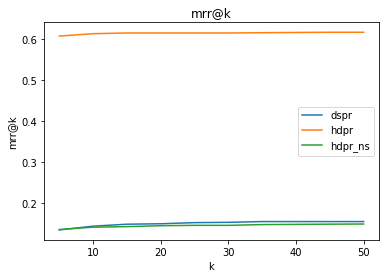

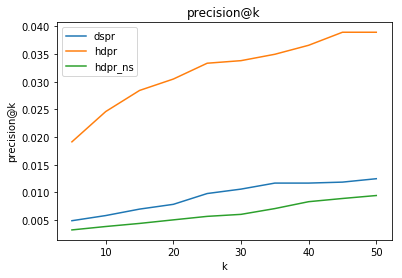

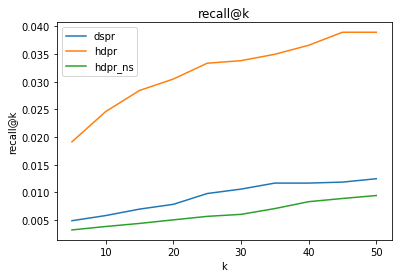

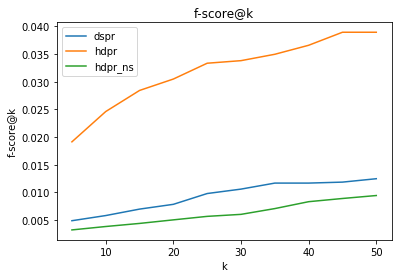

In [0]:
print('5 epoch, 1000 test items, 50 test users')
plot_metric('mrr')
plot_metric('precision')
plot_metric('recall')
plot_metric('f-score')